#### Deep Hallucination Classification

Mihai Matei [Data Science]



In [1]:
import sys
import os
import warnings
import shutil
from datetime import datetime
DATA_DIR='data_cv'
OUTPUT_DIR='output_cv'

def mount_gdrive():
    # Import the library and kaggle config files from gdrive
    GDRIVE_PATH='/content/gdrive/RESEARCH'
    if 'google.colab' in sys.modules:
        from google.colab import drive
        import shutil
        drive.mount('/content/gdrive')
        sys.path.append(GDRIVE_PATH)
        os.makedirs('/root/.kaggle/', exist_ok=True)
        shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
        !chmod 600 '/root/.kaggle/kaggle.json'

def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet pandas
    !pip install --quiet scikit-learn
    !pip install --quiet scikit-image
    !pip install --quiet scipy
    !pip install --quiet statsmodels
    !pip install --upgrade --quiet tensorflow
    !pip install --upgrade --quiet tensorflow-probability
    !pip install --quiet randomcolor
    !pip install --quiet matplotlib
    !pip install --quiet Pillow
    !pip install --quiet arviz
    !pip install --quiet seaborn
    !pip install --quiet prettytable

mount_gdrive()
#install_modules()

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.python.platform.build_info.build_info)

TRAIN_EPOCHS=50
VALIDATION_TRAIN_EPOCHS=30

Num GPUs Available:  1
{'cuda_version': '64_101', 'cudnn_version': '64_7', 'cuda_compute_capabilities': ['sm_35', 'sm_37', 'sm_52', 'sm_60', 'sm_61', 'compute_70'], 'cpu_compiler': 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.26.28801/bin/HostX64/x64/cl.exe', 'is_rocm_build': False, 'is_cuda_build': True, 'msvcp_dll_names': 'msvcp140.dll,msvcp140_1.dll', 'nvcuda_dll_name': 'nvcuda.dll', 'cudart_dll_name': 'cudart64_101.dll', 'cudnn_dll_name': 'cudnn64_7.dll'}


In [2]:
!git clone https://github.com/glypher/matmih.git
!git -C matmih pull

%reload_ext autoreload
%autoreload
import matmih as mm

fatal: destination path 'matmih' already exists and is not an empty directory.
git: 'credential-cache' is not a git command. See 'git --help'.


Already up to date.


#### Download the database
Create a kaggle account and an API token 
https://github.com/Kaggle/kaggle-api/blob/master/README.md

In [3]:
# Download the kaggle competition database
if not os.path.isfile(f'./{DATA_DIR}/train.txt'):
    import kaggle, zipfile
    kaggle.api.authenticate()
    kaggle.api.competition_download_files('dl-2020-unibuc-cv', path=f'./{DATA_DIR}')
    with zipfile.ZipFile(f'./{DATA_DIR}/dl-2020-unibuc-cv.zip') as z:
        z.extractall(f'./{DATA_DIR}')
    os.remove(f'./{DATA_DIR}/dl-2020-unibuc-cv.zip')

#### Hallucination data set


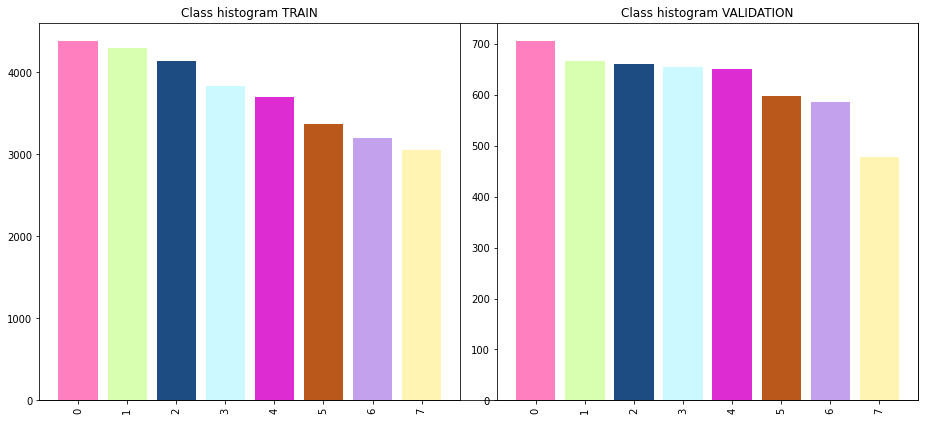

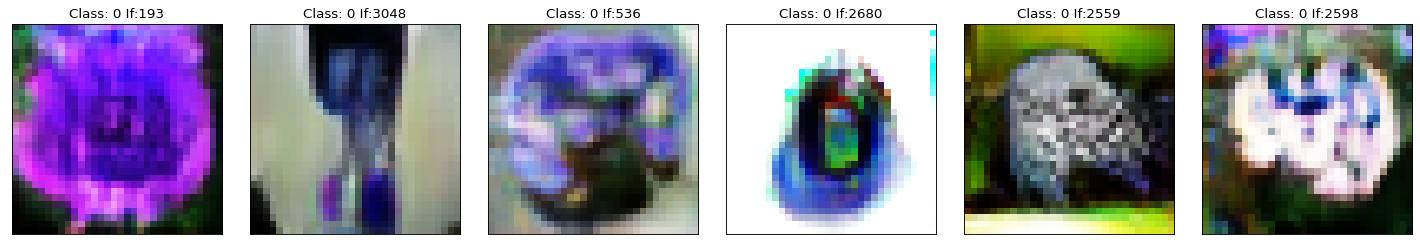

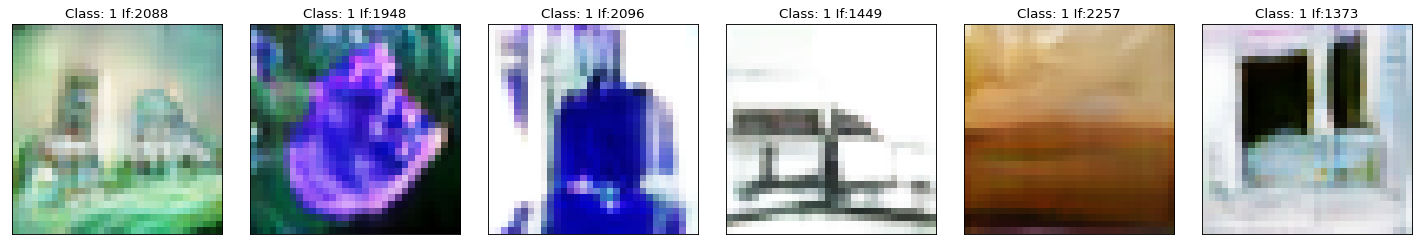

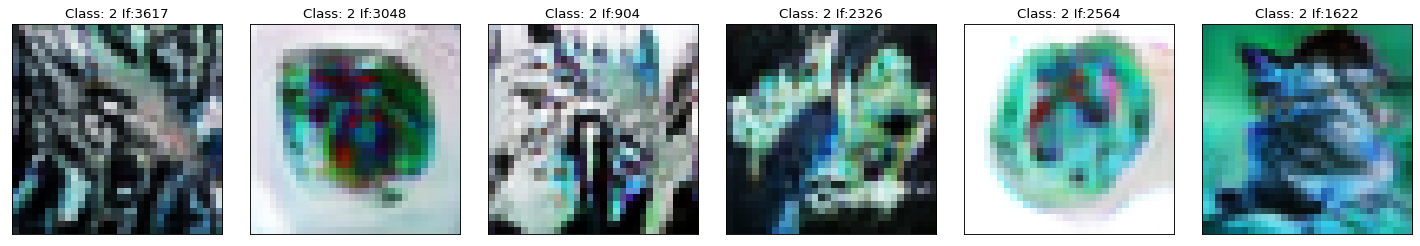

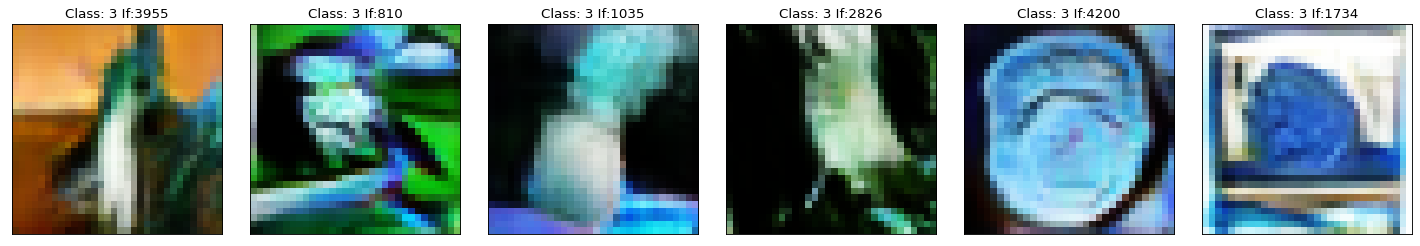

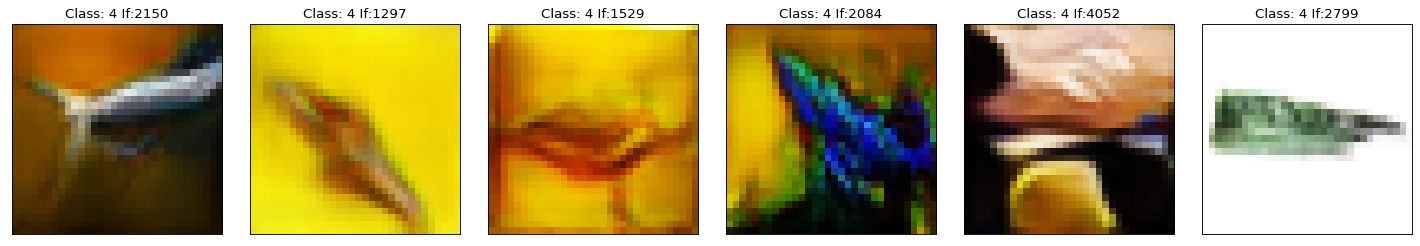

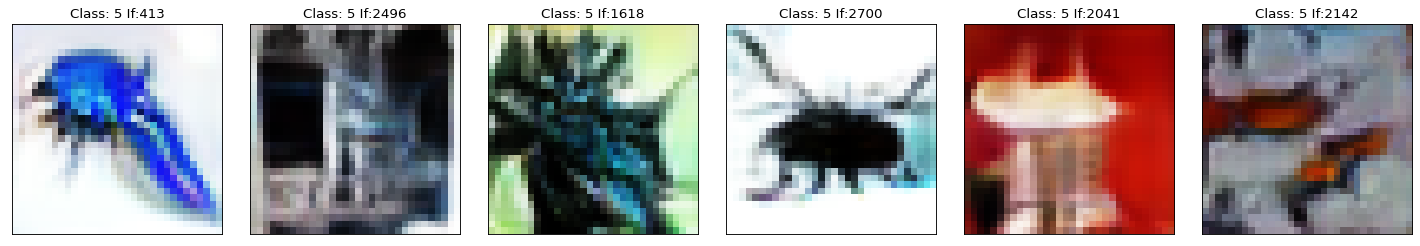

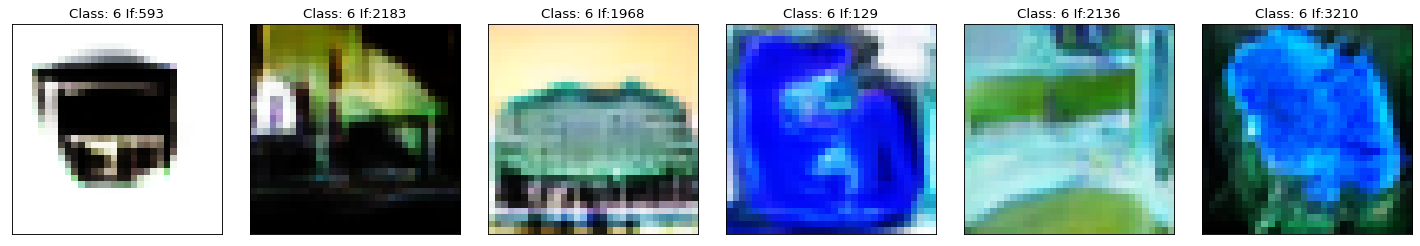

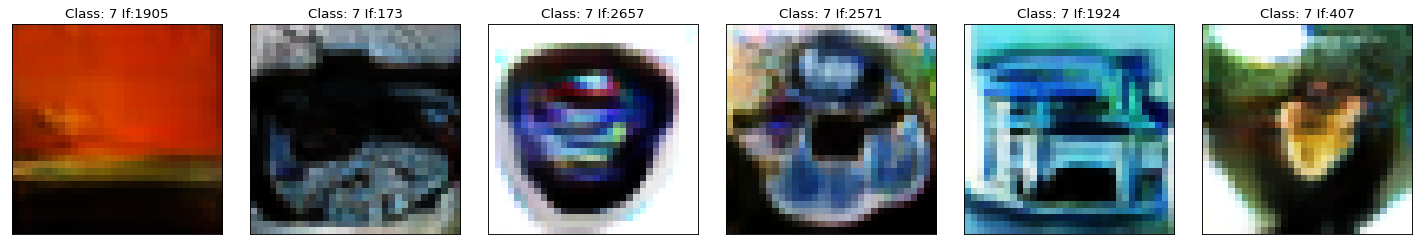

In [4]:
import numpy as np
import pandas as pd

def show_random_classes(df):
    import random
    from datetime import datetime
    random.seed(datetime.now())
    pb = mm.PlotBuilder()
    for cl in df['target'].cat.categories:
        class_df = df[df['target'] == cl]
        images = []
        titles = []
        for i in range(6):
            idx = random.randrange(len(class_df))
            titles.append('Class: {} If:{}'.format(cl, idx))
            images.append(class_df['path'].iloc[idx])
        pb.create_images(images, titles)
    pb.show()

def load_data(data_type):
    df = pd.read_csv(f"./{DATA_DIR}/{data_type}.txt", delimiter=',', names=['path', 'target'])
    df.dataframeName = data_type
    
    df['target'] = df['target'].astype('category')
    df['path'] = df['path'].apply(lambda row: os.path.join(DATA_DIR, data_type, row))
    df['features'] = df['path'].apply(lambda row: mm.Image.load(row, size=(32,32)))

    return df


trainDF = load_data('train')
valDF = load_data('validation')
testDF = load_data('test')
mm.PlotBuilder().create_histograms([trainDF['target'], valDF['target']],
                                   ['Class histogram TRAIN', 'Class histogram VALIDATION']).show()
show_random_classes(trainDF)

In [5]:
data_model = mm.DataModel(None, None)
data_model.set_train(np.stack( trainDF['features'].values ), trainDF['target'].values)
data_model.set_validation(np.stack( valDF['features'].values ), valDF['target'].values)
data_model.set_test(np.stack( testDF['features'].values ), testDF['target'].values)

# Normalize the features before proceeding
# This function is taken from the original tf repo. It ensures that all layers have a channel number that is divisible by 8
#  https://arxiv.org/abs/1801.04381
data_model = data_model.normalize_MobileNetV2()

### CNN Model
Use transfer learning to create a CNN Model starting from MobileNetV2.

All the models extend the matmih.model.Model class.

Added a multitude of hyperparameters to be tried:
* denseSize - first dense layer size
* denseL2 - first dense layer L2 regularization
* dropoutRate - dropout layer percentage
* trainEpochs - number of epochs to train
* class_weights - if the target class distribution should be taken into account when computing the loss
* optimizer - the Keras optimizer to use (will also include parameters as learning rate)

In [6]:
import sklearn
import tensorflow as tf
keras = tf.keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

class CNNModel(mm.TensorModel):
    # Create the base model from the pre-trained model MobileNet V2
    _base_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3),
                                                    weights=None,
                                                    include_top=False,
                                                    pooling='avg',
                                                   classes=8)
    _base_model.trainable = True
    # Uncomment the below line to get a summary of the layers involved in MobilNetV2
    _base_model.summary()
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        self._hyper_params = hyper_params.copy()
        model = tf.keras.Sequential([
                        CNNModel._base_model,
                        tf.keras.layers.Dense(hyper_params.get('denseSize', 128),
                                              kernel_initializer='glorot_uniform',
                                              kernel_regularizer=tf.keras.regularizers.l2(hyper_params.get('denseL2', 0.01)),
                                              bias_regularizer=tf.keras.regularizers.l2(hyper_params.get('denseL2', 0.01))),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Dropout(hyper_params.get('dropoutRate', 0.5)),
                        tf.keras.layers.Dense(hyper_params.get('noClasses', 8)),
                        tf.keras.layers.Activation('softmax')
                                              ])
        super(CNNModel, self).__init__(model)

        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())
        self._class_weights = hyper_params.get('class_weights', False)

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(5)])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        # save the weights of the best epoch to disk
        callbacks = [tf.keras.callbacks.ModelCheckpoint(self.best_weights_path, monitor='val_accuracy',
                                                        verbose=0, save_best_only=True,
                                                        save_weights_only=True, mode='auto')]
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = CNNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = CNNModel.np_to_tf(data_model.validation_features, data_model.validation_target)
        
        # compute the class weights to give to the model train target classes
        class_weights = None
        if self._class_weights:
            class_values = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                                           data_model.classes, data_model.train_target)
            class_values = class_values / np.min(class_values)
            class_weights = {c:class_values[c] for c in range(len(class_values))}

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  class_weight=class_weights,
                                  epochs=self._train_epochs, callbacks=callbacks)

        return mm.ModelHistory(self._hyper_params, history.history)

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        scores = self._model.predict(features_ds)
        return np.argmax(scores, axis=-1), scores

Num GPUs Available:  1
Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
_________________________________________________________

##### Hyper parameter space search
To check how our model works on different hyperparameters do a grid search using matmih.hyperparameters.HyperParamsLookup class.

After each model tried the tensorflow session is cleared. For the best model the weights are saved on disk

There are a total of 32 combinations that will be tried on the original dataset as well as the one augmented with the image generator.

In [ ]:
# Search the hyperparameter space for the best model
cnnHyperLookup = mm.HyperParamsLookup(CNNModel(), lambda hist: np.max(hist.history('accuracy', mm.DataType.VALIDATION)))
cnnHyperLookup.grid_search(data_model, True,
                           noClasses=[8],
                           trainEpochs=[TRAIN_EPOCHS],
                           denseSize=[128],
                           denseL2=[0.01],
                           dropoutRate=[0.5],
                           class_weights=[False],
                           optimizer=[tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                      #tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                                      #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True),
                                      tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)] )

Epoch 1/50
938/938 [==============================] - 20s 21ms/step - loss: 2.3044 - accuracy: 0.2365 - sparse_top_k_categorical_accuracy: 0.7669 - val_loss: 2.1444 - val_accuracy: 0.1194 - val_sparse_top_k_categorical_accuracy: 0.6388
Epoch 2/50
938/938 [==============================] - 19s 20ms/step - loss: 1.8868 - accuracy: 0.3076 - sparse_top_k_categorical_accuracy: 0.8447 - val_loss: 2.1449 - val_accuracy: 0.1412 - val_sparse_top_k_categorical_accuracy: 0.6388
Epoch 3/50
938/938 [==============================] - 18s 19ms/step - loss: 1.7809 - accuracy: 0.3555 - sparse_top_k_categorical_accuracy: 0.8730 - val_loss: 2.1214 - val_accuracy: 0.1412 - val_sparse_top_k_categorical_accuracy: 0.6388
Epoch 4/50
938/938 [==============================] - 18s 19ms/step - loss: 1.6957 - accuracy: 0.3885 - sparse_top_k_categorical_accuracy: 0.8875 - val_loss: 2.0272 - val_accuracy: 0.1714 - val_sparse_top_k_categorical_accuracy: 0.7430
Epoch 5/50
938/938 [==============================] - 18

Epoch 36/50
938/938 [==============================] - 18s 19ms/step - loss: 0.8508 - accuracy: 0.7326 - sparse_top_k_categorical_accuracy: 0.9667 - val_loss: 2.6007 - val_accuracy: 0.5140 - val_sparse_top_k_categorical_accuracy: 0.8924
Epoch 37/50
400/938 [===========>..................] - ETA: 10s - loss: 0.8260 - accuracy: 0.7376 - sparse_top_k_categorical_accuracy: 0.9712

##### Hyper parameter search model results
Plot the results of the hyperparameter model search.

The plots will contain the same color for the same model. The train metrics are ploted using dotted lines.

In [ ]:
ev = mm.ModelEvaluation(cnnHyperLookup.history)
ev.plot_history('Training history', ['accuracy', 'loss'])

##### CNN best model retrained
Reload the model using the saved weights in the hyper parameter search

In [ ]:
# Open tensor board
#result = mm.TensorBoard.open()

# Load the model again using the epoch with the highest validation accuracy
best_history = cnnHyperLookup.best_history
cnn_hyper_params = best_history.model_params.copy()
cnn_hyper_params['trainEpochs'] = np.argmax(best_history.history('accuracy', mm.DataType.VALIDATION)) + 1

print("CNN Model using {} lr={}\nvalidation accuracy={}".format(cnn_hyper_params,
                                                               tf.keras.backend.eval(cnn_hyper_params['optimizer'].lr),
                                                               best_history.history('accuracy', mm.DataType.VALIDATION)))
cnn_model = CNNModel(**cnn_hyper_params)
# Load the best checkpoint found the in training
cnn_model.load_weights(cnnHyperLookup.best_checkpoint)

# Save the model to the disk
cnn_model.save_model(name='best_model_{}'.format(datetime.now().strftime("%d_%m_%Y_%H_%M")))
# Optional load model
#cnn_model = mm.TensorModel.load()

#### CNN Model metrics
Plot the confusion matrix and Receiver Operating Caracteristic curve for the best model.

The ROC curve will be plotted for each class as well as an micro averaged dotted one for all classes.

In a binary classification an AUC of 0.5 (blue diagonal line) means that the model has no discriminative capacity to differenciate between the 2 classes.

When AUC is 0.7, it means there is 70% chance that model will be able to distinguish between positive class and negative class.
Usually an AUC of 0.8 is considered good.

In [ ]:
# Plot the confusion matrix and roc curve for the validation set
pred_targets, pred_scores = cnn_model.predict(data_model.validation_features)

pb = mm.PlotBuilder().create_confusion_matrix(
    data_model.validation_target, pred_targets, range(0, 8))

pb.create_roc_curve_multiclass(
    data_model.validation_target, pred_scores, range(0, 8), [True] * 8).show()

### Additional training on the validation set

In [ ]:
train_ds = CNNModel.np_to_tf(data_model.validation_features, data_model.validation_target)
history = cnn_model._model.fit(train_ds, epochs=VALIDATION_TRAIN_EPOCHS)

#### Model selection
Run the 2 models on the *test set* and check accuracy and metrics

Plot the test class distribution.

Plot the confusion matrix of the CNN model vs SVM model. Notice what classes both models predicted correctly

In [ ]:
cnn_test_target, cnn_test_scores = cnn_model.predict(data_model.test_features)

pb = mm.PlotBuilder().create_histograms([(cnn_test_target, range(0,8))], ['Predicted'])
pb.show()

### Save the result

In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = f'{OUTPUT_DIR}/Mihai_Matei_submission_{datetime.now().strftime("%d_%m_%Y_%H_%M")}.txt'
with open(output_path, 'w') as f:
    f.write('id,label\n')
    for i in range(len(cnn_test_target)):
        f.write("{},{}\n".format(os.path.basename(testDF['path'].iloc[i]), cnn_test_target[i]))